In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

## Read in Data

In [3]:
links = pd.read_csv('./data/ml-latest-small/links.csv')
movies = pd.read_csv('./data/ml-latest-small/movies.csv')
ratings = pd.read_csv('./data/ml-latest-small/ratings.csv')
tags = pd.read_csv('./data/ml-latest-small/tags.csv')

In [4]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Clean Data & Feature Engineering

In [8]:
#extract year from movie title
movies['year'] = movies.title.str.extract(r'\((\d{4})\)')
movies.year = np.where(movies.year.isnull() == True,1899,movies.year).astype(int)

In [9]:
#get average rating and total number of ratings for each movie
movies = movies.join(ratings.groupby('movieId').rating.describe()[['count','mean']],on='movieId')

In [10]:
#parse genres and get dummy cols for each genre

movies = movies.join(pd.get_dummies(movies.genres.str.split('|').apply(pd.Series).stack()).sum(level=0))

In [11]:
#rename cols for ease of use
movies.rename(columns={'count':'num_ratings','mean':'avg_rating',
                       '(no genres listed)':'no_genre_listed','Film-Noir':'FilmNoir',
                       'Sci-Fi':'SciFi'},inplace=True)

In [12]:
#drop uneeded timestamp from ratings for use in surprise
ratings.drop(columns=['timestamp'],inplace=True)

## Exploratory Data Analysis

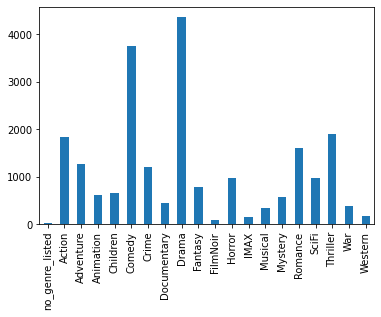

In [13]:
#distribution of grenres, high imbalance, will be much easier to guess drama, comedy, because of size, but also
# may not be specific enough to make quality reccomendations
# but if genre is small and rated highly easy to reccomend other movies in that genre
movies.loc[:,'no_genre_listed':].sum().plot(kind = 'bar')

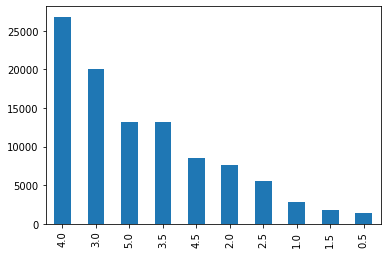

In [14]:
#most people rate >3.0 meaning that people tend to not give negative reviews, <2.5 
#could be a type of move to really avoid
ratings.rating.value_counts().plot(kind='bar')

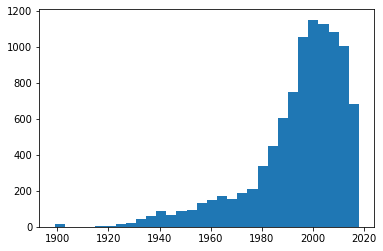

In [15]:
#distribution of movies releases
plt.hist(movies.year,bins = 30);

## Build Recommendation Engine

In [16]:
import surprise

In [17]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, GridSearchCV

In [18]:
from surprise.prediction_algorithms import knns, SVD, SVDpp
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

### Prep Data

#### Load into Surprise

In [19]:
surprise_movies = Dataset.load_from_df(ratings,Reader(rating_scale=(0,5)))

#### Train Test Split

In [20]:
train, test = train_test_split(surprise_movies, test_size = 0.2)

In [21]:
print('Number of Users: ', train.n_users)
print('Number of items: ', train.n_items)
print('Number of ratings: ', train.n_ratings)

Number of Users:  610
Number of items:  8962
Number of ratings:  80668


### KNearest Neighbors

Using Cosine Similarity

#### Basic KNN

In [22]:
basic_knn = knns.KNNBasic(sim_options={'name':'cosine','user_based':True})
basic_knn.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [23]:
basic_knn.sim

array([[1.        , 0.98391032, 0.97829553, ..., 0.97170071, 0.99922929,
        0.98706943],
       [0.98391032, 1.        , 0.9661754 , ..., 0.98627052, 0.99352363,
        0.99342616],
       [0.97829553, 0.9661754 , 1.        , ..., 0.98118954, 0.95341791,
        0.95912911],
       ...,
       [0.97170071, 0.98627052, 0.98118954, ..., 1.        , 0.96827732,
        1.        ],
       [0.99922929, 0.99352363, 0.95341791, ..., 0.96827732, 1.        ,
        0.98994949],
       [0.98706943, 0.99342616, 0.95912911, ..., 1.        , 0.98994949,
        1.        ]])

In [24]:
predictions = basic_knn.test(test)
print(accuracy.rmse(predictions))

RMSE: 0.9674
0.9673604438106528


#### KNN Using Pearson 

In [25]:
basic_knn = knns.KNNBasic(sim_options={'name':'pearson','user_based':True})
basic_knn.fit(train)
predictions = basic_knn.test(test)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9700
0.9700047460293619


#### KNN With Means

In [26]:
knn_means = knns.KNNWithMeans(sim_options={'name':'pearson','user_based':True})
knn_means.fit(train)
predictions = basic_knn.test(test)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9700
0.9700047460293619


### SVD

In [27]:
#grid search over SVD

params = {'n_factors':[10,20,50,100],
         'reg_all': [.01,.02,.05,.75,.1]}

grid_svd = GridSearchCV(SVD, param_grid=params,n_jobs=-1,joblib_verbose=1,cv=5)

grid_svd.fit(surprise_movies)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished


In [28]:
print(grid_svd.best_score)
print(grid_svd.best_params)

{'rmse': 0.8690088366074237, 'mae': 0.6679835662968449}
{'rmse': {'n_factors': 10, 'reg_all': 0.02}, 'mae': {'n_factors': 20, 'reg_all': 0.02}}


In [29]:
svd = SVD(n_factors= 50, reg_all=.05)
svd.fit(train)
svd.predict(2,4)

Prediction(uid=2, iid=4, r_ui=None, est=3.093865317987561, details={'was_impossible': False})

In [30]:
movies.describe()

,movieId,year,num_ratings,avg_rating,no_genre_listed,Action,Adventure,Animation,Children,Comedy,...,FilmNoir,Horror,IMAX,Musical,Mystery,Romance,SciFi,Thriller,War,Western
count,9742.000000,9742.000000,9724.000000,9724.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,...,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000
mean,42200.353623,1994.486040,10.369807,3.262448,0.003490,0.187641,0.129645,0.062718,0.068158,0.385547,...,0.008930,0.100390,0.016218,0.034285,0.058817,0.163827,0.100595,0.194416,0.039212,0.017142
std,52160.494854,18.848876,22.401005,0.869874,0.058976,0.390445,0.335930,0.242468,0.252031,0.486749,...,0.094083,0.300535,0.126321,0.181968,0.235295,0.370137,0.300808,0.395771,0.194108,0.129808
min,1.000000,1899.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3248.250000,1987.000000,1.000000,2.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7300.000000,1999.000000,3.000000,3.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,76232.000000,2008.000000,9.000000,3.911765,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,193609.000000,2018.000000,329.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [82]:
movies[movies.year >= 2010]

,movieId,title,genres,year,num_ratings,avg_rating,no_genre_listed,Action,Adventure,Animation,...,FilmNoir,Horror,IMAX,Musical,Mystery,Romance,SciFi,Thriller,War,Western
7221,73268,Daybreakers (2010),Action|Drama|Horror|Thriller,2010,6.0,3.416667,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
7223,73319,Leap Year (2010),Comedy|Romance,2010,5.0,2.400000,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7224,73321,"Book of Eli, The (2010)",Action|Adventure|Drama,2010,16.0,3.281250,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
7244,73929,Legion (2010),Action|Fantasy|Horror|Thriller,2010,3.0,2.833333,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
7248,74154,When in Rome (2010),Comedy|Romance,2010,4.0,2.500000,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9736,193579,Jon Stewart Has Left the Building (2015),Documentary,2015,1.0,3.500000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017,1.0,4.000000,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017,1.0,3.500000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),Drama,2017,1.0,3.500000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
def movie_rater(movies, num, genre=None, year=0):
    userId = 1000
    user_ratings = []
    while num > 0:
        if genre:
            if year >1900:
                movie = movies[(movies.year >= year) & (movies.genres.str.contains(genre))].sample(1)
            else:
                movie = movies[movies.genres.str.contains(genre)].sample(1)
        elif year:
            movie = movies[movies.year >= year].sample(1)
        else:
            movie = movies.sample(1)
            
        rating = input('''Rate this movie on a scale of 0-5 or press n if you haven\'t seen it: \n'''+
                      str(movie[['title','genres','year']])+'\n')
        
        if rating == 'n' or rating == '':
            continue
        else:
            user_ratings.append({
                'userId':userId,
                'movieId':movie['movieId'].values[0],
                'rating':rating
            })
            num -= 1
    return user_ratings

In [84]:
insert_ratings = movie_rater(movies, 5, genre='Drama',year=2010)

Rate this movie on a scale of 0-5 or press n if you haven't seen it: 
                       title        genres  year
9446  A Dog's Purpose (2017)  Comedy|Drama  2017
 n
Rate this movie on a scale of 0-5 or press n if you haven't seen it: 
                                 title                      genres  year
8346  Jack Ryan: Shadow Recruit (2014)  Action|Drama|Thriller|IMAX  2014
 
Rate this movie on a scale of 0-5 or press n if you haven't seen it: 
                            title                genres  year
7647  Crazy, Stupid, Love. (2011)  Comedy|Drama|Romance  2011
 
Rate this movie on a scale of 0-5 or press n if you haven't seen it: 
                title genres  year
8767  I'm Here (2010)  Drama  2010
 
Rate this movie on a scale of 0-5 or press n if you haven't seen it: 
                   title        genres  year
7588  Melancholia (2011)  Drama|Sci-Fi  2011
 
Rate this movie on a scale of 0-5 or press n if you haven't seen it: 
                title              genres

In [85]:
movies_rated = ratings.append(insert_ratings,ignore_index=True)
surprise_data = Dataset.load_from_df(movies_rated,Reader(rating_scale=(0,5)))

svd_user = SVD(n_factors=50, reg_all=.05)
svd_user.fit(surprise_data.build_full_trainset())

In [86]:
recommendations = []
for film in movies_rated['movieId'].unique():
    recommendations.append((film, svd.predict(1000,film)[3]))

top_recs = sorted(recommendations, key = lambda x:x[1],reverse=True)

In [87]:
def show_top_recs(top_recs,n):
    print('Recommendations:')
    for i, film in enumerate(top_recs):
        print(movies.loc[movies['movieId'] == int(film[0])].title.values[0])
        n-=1
        if n==0:
            break

show_top_recs(top_recs,5)

Recommendations:
Seven Samurai (Shichinin no samurai) (1954)
Shawshank Redemption, The (1994)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
Apocalypse Now (1979)
Lawrence of Arabia (1962)


In [88]:
def movie_reccomender(movies, num_ratings, num_recs, genre=None, year = 0):
    user_input = movie_rater(movies,num_ratings,genre,year)
    
    movies_rated = ratings.append(insert_ratings,ignore_index=True)
    surprise_data = Dataset.load_from_df(movies_rated,Reader(rating_scale=(0,5)))

    svd_user = SVD(n_factors=50, reg_all=.05)
    svd_user.fit(surprise_data.build_full_trainset())
    
    recommendations = []
    for film in movies_rated['movieId'].unique():
        recommendations.append((film, svd.predict(1000,film)[3]))

    top_recs = sorted(recommendations, key = lambda x:x[1],reverse=True)
    
    show_top_recs(top_recs, num_recs)
    